# Importing Libraries

In [ ]:
import os
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split, Dataset

from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, accuracy_score

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
2

# Load Dataset

In [ ]:
data_dir = "./data"
basic_transform = transforms.Compose([
    transforms.Resize((224, 224))   # just to load and inspect
])
full_dataset = datasets.Caltech256(
    root=data_dir,
    transform=basic_transform,
    download=True
)
print("Total images in full Caltech256:", len(full_dataset))
print("Total classes:", len(full_dataset.categories))

In [27]:
# choose first 10 classes
subset_class_indices = list(range(10))
max_images_per_class = 1000

if hasattr(full_dataset, "categories"):
    subset_class_names = [full_dataset.categories[i]
                          for i in subset_class_indices]
else:
    subset_class_names = [str(i) for i in subset_class_indices]

print("Using classes:")
for i, name in zip(subset_class_indices, subset_class_names):
    print(i, name)

# build list of indices we want
class_counts = defaultdict(int)
subset_indices = []

for idx in range(len(full_dataset)):
    _, label = full_dataset[idx]
    if label in subset_class_indices:
        if class_counts[label] < max_images_per_class:
            subset_indices.append(idx)
            class_counts[label] += 1

print("\nImages per chosen class:")
for cls in subset_class_indices:
    print(cls, subset_class_names[cls], "->", class_counts[cls])

caltech_subset = Subset(full_dataset, subset_indices)
print("\nTotal images in subset:", len(caltech_subset))

Using classes:
0 001.ak47
1 002.american-flag
2 003.backpack
3 004.baseball-bat
4 005.baseball-glove
5 006.basketball-hoop
6 007.bat
7 008.bathtub
8 009.bear
9 010.beer-mug

Images per chosen class:
0 001.ak47 -> 98
1 002.american-flag -> 97
2 003.backpack -> 151
3 004.baseball-bat -> 127
4 005.baseball-glove -> 148
5 006.basketball-hoop -> 90
6 007.bat -> 106
7 008.bathtub -> 232
8 009.bear -> 102
9 010.beer-mug -> 94

Total images in subset: 1245


# Spliting into test, train and Val

In [28]:
dataset_size = len(caltech_subset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(
    caltech_subset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label


train_dataset = TransformDataset(train_subset, train_transform)
val_dataset = TransformDataset(val_subset, eval_transform)
test_dataset = TransformDataset(test_subset, eval_transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=2, pin_memory=True)

print("Data loaders are ready!")

Data loaders are ready!


# Pre trained Resnet18

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(subset_class_indices)

# load resnet18 with ImageNet weights
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freeze all layers first (we only train the last layer)
for param in resnet.parameters():
    param.requires_grad = False

# replace the final fully-connected layer
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

resnet = resnet.to(device)

print(resnet.fc)  # just to check

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)

Linear(in_features=512, out_features=10, bias=True)


# Training

In [30]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        resnet, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = eval_one_epoch(
        resnet, val_loader, criterion, device
    )

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%"
    )

print("Training finished!")

Epoch 1/10 | Train Loss: 1.9338, Train Acc: 39.04% | Val Loss: 1.1568, Val Acc: 75.27%
Epoch 2/10 | Train Loss: 1.3095, Train Acc: 64.06% | Val Loss: 0.7249, Val Acc: 86.56%
Epoch 3/10 | Train Loss: 1.0567, Train Acc: 72.33% | Val Loss: 0.5610, Val Acc: 87.10%
Epoch 4/10 | Train Loss: 0.8638, Train Acc: 78.53% | Val Loss: 0.4926, Val Acc: 86.56%
Epoch 5/10 | Train Loss: 0.7637, Train Acc: 80.60% | Val Loss: 0.4546, Val Acc: 86.56%
Epoch 6/10 | Train Loss: 0.7255, Train Acc: 80.48% | Val Loss: 0.3850, Val Acc: 88.71%
Epoch 7/10 | Train Loss: 0.6444, Train Acc: 81.86% | Val Loss: 0.3819, Val Acc: 87.63%
Epoch 8/10 | Train Loss: 0.6098, Train Acc: 81.75% | Val Loss: 0.3576, Val Acc: 88.17%
Epoch 9/10 | Train Loss: 0.5994, Train Acc: 81.29% | Val Loss: 0.3636, Val Acc: 89.25%
Epoch 10/10 | Train Loss: 0.5604, Train Acc: 85.07% | Val Loss: 0.3220, Val Acc: 89.25%
Training finished!


In [31]:
# ============================================
# 5. Test evaluation + simple report
# ============================================

resnet.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_acc*100:.2f}%\n")

print("Classification report (test set):")
print(classification_report(all_labels, all_preds,
                            target_names=subset_class_names))


Test Accuracy: 93.62%

Classification report (test set):
                     precision    recall  f1-score   support

           001.ak47       1.00      0.88      0.94        17
  002.american-flag       1.00      1.00      1.00        15
       003.backpack       0.85      0.92      0.88        24
   004.baseball-bat       0.92      0.80      0.86        15
 005.baseball-glove       0.88      1.00      0.94        36
006.basketball-hoop       1.00      0.86      0.92         7
            007.bat       0.92      0.86      0.89        14
        008.bathtub       1.00      0.97      0.99        39
           009.bear       0.92      0.92      0.92        13
       010.beer-mug       1.00      1.00      1.00         8

           accuracy                           0.94       188
          macro avg       0.95      0.92      0.93       188
       weighted avg       0.94      0.94      0.94       188



In [32]:
# ================================================================
# HYPERPARAMETER TUNING
# ================================================================

def create_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader

def build_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)
    return model

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

learning_rates = [1e-3]
batch_sizes    = [32]
num_epochs_tuning = 15   # small number for quick comparison

criterion = nn.CrossEntropyLoss()
tuning_results = []

exp_id = 0
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n===== Experiment, LR={lr}, BatchSize={bs} ====")

        train_loader, val_loader, _ = create_loaders(bs)

        model_hp = build_model(num_classes)
        optimizer = optim.Adam(model_hp.fc.parameters(), lr=lr, weight_decay=1e-4)

        best_val_acc = 0.0
        best_epoch = 0

        for epoch in range(num_epochs_tuning):
            train_loss, train_acc = train_one_epoch(model_hp, train_loader, optimizer, criterion, device)
            val_loss, val_acc     = evaluate(model_hp, val_loader, criterion, device)

            print(
                f"Epoch {epoch+1}/{num_epochs_tuning} "
                f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% "
                f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%"
            )

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch + 1

        tuning_results.append({
            "experiment": exp_id,
            "learning_rate": lr,
            "batch_size": bs,
            "best_val_acc": best_val_acc,
            "best_epoch": best_epoch
        })

# Print tuning summary
print("\n===== Hyperparameter Tuning Summary =====")
print(f"{'Exp':<5} {'LR':<10} {'Batch':<8} {'Best Val Acc (%)':<18} {'Best Epoch':<11}")
for r in tuning_results:
    print(
        f"{r['experiment']:<5} "
        f"{r['learning_rate']:<10} "
        f"{r['batch_size']:<8} "
        f"{r['best_val_acc']*100: <18.2f} "
        f"{r['best_epoch']:<11}"
    )

# Pick best config
best_cfg = max(tuning_results, key=lambda d: d["best_val_acc"])
best_lr = best_cfg["learning_rate"]
best_bs = best_cfg["batch_size"]

print("\nBest config:")
print(best_cfg)



===== Experiment, LR=0.001, BatchSize=32 ====
Epoch 1/15 | Train Loss: 1.9413, Train Acc: 35.71% | Val Loss: 1.2888, Val Acc: 68.28%
Epoch 2/15 | Train Loss: 1.2959, Train Acc: 67.16% | Val Loss: 0.8217, Val Acc: 77.96%
Epoch 3/15 | Train Loss: 1.0141, Train Acc: 74.63% | Val Loss: 0.5880, Val Acc: 85.48%
Epoch 4/15 | Train Loss: 0.8369, Train Acc: 78.76% | Val Loss: 0.4641, Val Acc: 87.10%
Epoch 5/15 | Train Loss: 0.7499, Train Acc: 80.60% | Val Loss: 0.4291, Val Acc: 88.17%
Epoch 6/15 | Train Loss: 0.7024, Train Acc: 81.06% | Val Loss: 0.4165, Val Acc: 88.71%
Epoch 7/15 | Train Loss: 0.6352, Train Acc: 83.70% | Val Loss: 0.3348, Val Acc: 90.86%
Epoch 8/15 | Train Loss: 0.6176, Train Acc: 83.24% | Val Loss: 0.3242, Val Acc: 90.86%
Epoch 9/15 | Train Loss: 0.5731, Train Acc: 85.07% | Val Loss: 0.3377, Val Acc: 91.40%
Epoch 10/15 | Train Loss: 0.5689, Train Acc: 84.04% | Val Loss: 0.3293, Val Acc: 88.71%
Epoch 11/15 | Train Loss: 0.5506, Train Acc: 83.70% | Val Loss: 0.3071, Val Acc: 8

In [33]:
# ================================================================
# FINAL TRAINING WITH BEST HYPERPARAMETERS + EARLY STOPPING
# ================================================================
train_loader, val_loader, test_loader = create_loaders(best_bs)
model_final = build_model(num_classes)
optimizer_final = optim.Adam(model_final.fc.parameters(), lr=best_lr, weight_decay=1e-4)

epochs = 15
patience = 3
best_val_loss = np.inf
patience_counter = 0
best_weights = None

train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("\nStarting final training with best hyperparameters...\n")

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_final, train_loader, optimizer_final, criterion, device)
    val_loss, val_acc     = evaluate(model_final, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model_final.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

if best_weights is not None:
    model_final.load_state_dict(best_weights)



Starting final training with best hyperparameters...

Epoch 1/15
Train Loss: 1.9936 | Train Acc: 31.57%
Val Loss:   1.3025 | Val Acc:   70.43%

Epoch 2/15
Train Loss: 1.3732 | Train Acc: 61.77%
Val Loss:   0.8608 | Val Acc:   74.19%

Epoch 3/15
Train Loss: 1.0753 | Train Acc: 71.18%
Val Loss:   0.6295 | Val Acc:   84.95%

Epoch 4/15
Train Loss: 0.9054 | Train Acc: 76.12%
Val Loss:   0.5294 | Val Acc:   84.41%

Epoch 5/15
Train Loss: 0.7829 | Train Acc: 79.68%
Val Loss:   0.4703 | Val Acc:   84.95%

Epoch 6/15
Train Loss: 0.6997 | Train Acc: 83.01%
Val Loss:   0.4218 | Val Acc:   87.63%

Epoch 7/15
Train Loss: 0.6731 | Train Acc: 81.29%
Val Loss:   0.4001 | Val Acc:   86.56%

Epoch 8/15
Train Loss: 0.6383 | Train Acc: 81.86%
Val Loss:   0.3650 | Val Acc:   88.17%

Epoch 9/15
Train Loss: 0.5826 | Train Acc: 83.35%
Val Loss:   0.3438 | Val Acc:   89.25%

Epoch 10/15
Train Loss: 0.5904 | Train Acc: 82.78%
Val Loss:   0.3489 | Val Acc:   88.17%

Epoch 11/15
Train Loss: 0.5680 | Train Acc: 

In [ ]:

# ================================================================
# PLOT CONVERGENCE (LOSS + ACC)
# ================================================================

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", linestyle="dotted")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_accs, label="Train Acc", linestyle="dotted")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Convergence")
plt.legend()
plt.tight_layout()
plt.show()


===== FINAL TEST RESULTS =====
Test Accuracy: 95.21%

Per-class Test Metrics:
001.ak47        | Prec: 1.000 | Rec: 0.941 | F1: 0.970 | Support: 17
002.american-flag | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 15
003.backpack    | Prec: 0.828 | Rec: 1.000 | F1: 0.906 | Support: 24
004.baseball-bat | Prec: 0.933 | Rec: 0.933 | F1: 0.933 | Support: 15
005.baseball-glove | Prec: 1.000 | Rec: 0.944 | F1: 0.971 | Support: 36
006.basketball-hoop | Prec: 1.000 | Rec: 0.857 | F1: 0.923 | Support: 7
007.bat         | Prec: 0.923 | Rec: 0.857 | F1: 0.889 | Support: 14
008.bathtub     | Prec: 1.000 | Rec: 0.974 | F1: 0.987 | Support: 39
009.bear        | Prec: 0.923 | Rec: 0.923 | F1: 0.923 | Support: 13
010.beer-mug    | Prec: 0.889 | Rec: 1.000 | F1: 0.941 | Support: 8

Classification Report (Test Set):
                     precision    recall  f1-score   support

           001.ak47       1.00      0.94      0.97        17
  002.american-flag       1.00      1.00      1.00        15
    

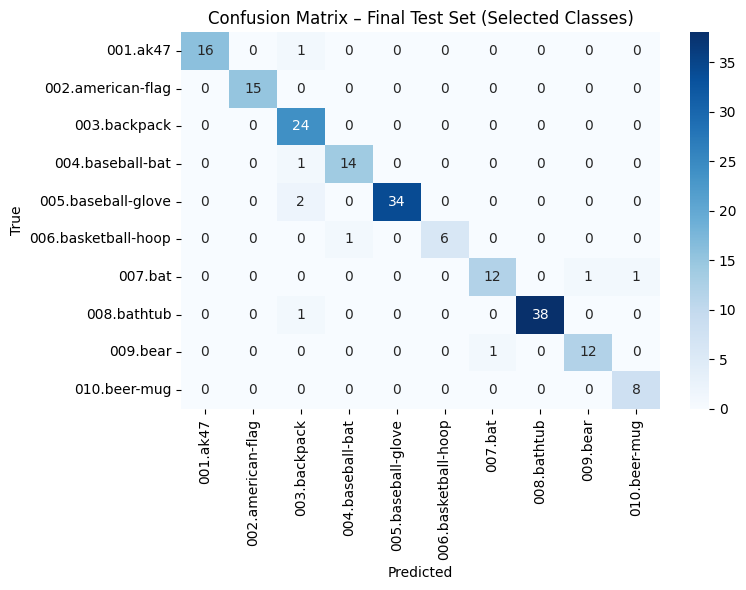

In [34]:


# ================================================================
# FINAL EVALUATION ON TEST SET
# ================================================================
model_final.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        # images are already normalized by eval_transform

        outputs = model_final(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_acc = accuracy_score(all_labels, all_preds)
print(f"\n===== FINAL TEST RESULTS =====")
print(f"Test Accuracy: {test_acc*100:.2f}%")

prec, rec, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

print("\nPer-class Test Metrics:")
for i, cls_name in enumerate(subset_class_names):
    print(f"{cls_name:15s} | Prec: {prec[i]:.3f} | Rec: {rec[i]:.3f} | F1: {f1[i]:.3f} | Support: {support[i]}")

print("\nClassification Report (Test Set):")
print(classification_report(all_labels, all_preds, target_names=subset_class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=subset_class_names,
            yticklabels=subset_class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Final Test Set (Selected Classes)")
plt.tight_layout()
plt.show()

In [35]:
# Overall accuracy
val_acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# Per-class precision, recall, F1
prec, rec, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

print("\nPer-class metrics:")
for i, cls_name in enumerate(subset_class_names):
    print(f"{cls_name:15s} | Prec: {prec[i]:.3f} | Rec: {rec[i]:.3f} | F1: {f1[i]:.3f} | Support: {support[i]}")

# Macro / weighted metrics
print("\nClassification Report (macro/weighted):")
print(classification_report(all_labels, all_preds, target_names=subset_class_names, zero_division=0))

Validation Accuracy: 95.21%

Per-class metrics:
001.ak47        | Prec: 1.000 | Rec: 0.941 | F1: 0.970 | Support: 17
002.american-flag | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 15
003.backpack    | Prec: 0.828 | Rec: 1.000 | F1: 0.906 | Support: 24
004.baseball-bat | Prec: 0.933 | Rec: 0.933 | F1: 0.933 | Support: 15
005.baseball-glove | Prec: 1.000 | Rec: 0.944 | F1: 0.971 | Support: 36
006.basketball-hoop | Prec: 1.000 | Rec: 0.857 | F1: 0.923 | Support: 7
007.bat         | Prec: 0.923 | Rec: 0.857 | F1: 0.889 | Support: 14
008.bathtub     | Prec: 1.000 | Rec: 0.974 | F1: 0.987 | Support: 39
009.bear        | Prec: 0.923 | Rec: 0.923 | F1: 0.923 | Support: 13
010.beer-mug    | Prec: 0.889 | Rec: 1.000 | F1: 0.941 | Support: 8

Classification Report (macro/weighted):
                     precision    recall  f1-score   support

           001.ak47       1.00      0.94      0.97        17
  002.american-flag       1.00      1.00      1.00        15
       003.backpack       0.8

In [36]:
# ================================================================
# FINE-TUNING AND ITERATION
# ================================================================

best_lr = 1e-3
best_bs = 32

# Rebuild loaders with best batch size
train_loader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=best_bs, shuffle=False)

# Rebuild model starting from pretrained weights
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = 10

# 1) Freeze everything first
for p in model_ft.parameters():
    p.requires_grad = False

# 2) Unfreeze last residual block and FC for fine-tuning
for p in model_ft.layer4.parameters():
    p.requires_grad = True
model_ft.fc = nn.Linear(512, num_classes)
for p in model_ft.fc.parameters():
    p.requires_grad = True

model_ft = model_ft.to(device)

# Use smaller LR for fine-tuning
optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=best_lr,
    weight_decay=1e-4
)
criterion = nn.CrossEntropyLoss()

# Reuse your existing train_one_epoch / evaluate functions
epochs_finetune = 10
best_val_acc = 0.0
best_weights = None

for epoch in range(epochs_finetune):
    train_loss, train_acc = train_one_epoch(model_ft, train_loader, optimizer_ft, criterion, device)
    val_loss, val_acc     = evaluate(model_ft, val_loader, criterion, device)

    print(f"[Fine-tune] Epoch {epoch+1}/{epochs_finetune} "
          f"| Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = model_ft.state_dict()

# Load best fine-tuned weights
if best_weights is not None:
    model_ft.load_state_dict(best_weights)


[Fine-tune] Epoch 1/10 | Train Acc: 69.23% | Val Acc: 89.78%
[Fine-tune] Epoch 2/10 | Train Acc: 76.81% | Val Acc: 84.95%
[Fine-tune] Epoch 3/10 | Train Acc: 84.04% | Val Acc: 85.48%
[Fine-tune] Epoch 4/10 | Train Acc: 82.43% | Val Acc: 89.25%
[Fine-tune] Epoch 5/10 | Train Acc: 85.42% | Val Acc: 87.63%
[Fine-tune] Epoch 6/10 | Train Acc: 87.49% | Val Acc: 89.25%
[Fine-tune] Epoch 7/10 | Train Acc: 87.60% | Val Acc: 89.78%
[Fine-tune] Epoch 8/10 | Train Acc: 87.37% | Val Acc: 89.25%
[Fine-tune] Epoch 9/10 | Train Acc: 89.78% | Val Acc: 90.86%
[Fine-tune] Epoch 10/10 | Train Acc: 89.44% | Val Acc: 90.86%


In [ ]:
# ============================================
# FINAL MODEL TESTING
# ============================================
test_loss, test_acc = evaluate(model_ft, test_loader, criterion, device)

print("\n===== FINAL TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")


In [37]:
torch.save(model_ft.state_dict(), "resnet18_caltech256.pth")

# GRAD-CAM SECTION


In [38]:
grad_model = model_ft
grad_model.eval()

# use the last conv layer in ResNet18
target_layer = grad_model.layer4[-1].conv2

In [39]:
activations = None
gradients = None

def forward_hook(module, inp, out):
    global activations
    activations = out.detach()

def backward_hook(module, grad_in, grad_out):
    global gradients
    # grad_out[0] is gradient wrt the output of this layer
    gradients = grad_out[0].detach()

# register hooks
_ = target_layer.register_forward_hook(forward_hook)
_ = target_layer.register_full_backward_hook(backward_hook)

In [44]:
import torch.nn.functional as F

def generate_gradcam(input_tensor, model, class_idx=None):
    """
    input_tensor: 1 x 3 x H x W (already normalized)
    returns: 2D heatmap (numpy array in [0,1]) with same H,W as input
    """
    global activations, gradients

    activations = None
    gradients = None

    # forward pass
    output = model(input_tensor)          # shape: [1, num_classes]

    if class_idx is None:
        class_idx = output.argmax(dim=1).item()

    score = output[:, class_idx]
    model.zero_grad()

    # backward to get gradients at target layer
    score.backward(retain_graph=True)

    # GAP over gradients
    # gradients: [1, C, H', W']
    alpha = gradients.mean(dim=(2, 3), keepdim=True)   # [1, C, 1, 1]

    # weighted sum of activations
    cam = (alpha * activations).sum(dim=1, keepdim=True)  # [1,1,H',W']

    # ReLU
    cam = torch.relu(cam)

    # 🔴 IMPORTANT: upsample to input size (H, W)
    cam = F.interpolate(
        cam,
        size=input_tensor.shape[2:],   # (H, W)
        mode="bilinear",
        align_corners=False
    )  # now [1,1,H,W]

    # normalize to [0,1]
    cam = cam.squeeze().cpu().numpy()   # H x W
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    return cam, class_idx


In [41]:
imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
imagenet_std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

def denormalize(img_tensor):
    """
    img_tensor: 3 x H x W (PyTorch tensor)
    returns: H x W x 3 (numpy image in [0,1])
    """
    img = img_tensor.detach().cpu().numpy()
    img = img * imagenet_std + imagenet_mean
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))   # CHW -> HWC
    return img


In [45]:
def show_gradcam_gallery(model, dataset, class_names, num_images=6):
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(15, 10))

    for idx, data_idx in enumerate(indices):
        img_tensor, true_label = dataset[data_idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)

        # heatmap is now same size as image (H,W)
        heatmap, pred_class = generate_gradcam(input_tensor, model)

        orig_img = denormalize(img_tensor)   # (H,W,3) in [0,1]

        # make colored heatmap
        heatmap_rgb = plt.cm.jet(heatmap)[:, :, :3]   # (H,W,3)

        # overlay
        overlay = 0.6 * orig_img + 0.4 * heatmap_rgb
        overlay = np.clip(overlay, 0, 1)

        plt.subplot(2, num_images // 2, idx + 1)
        plt.imshow(overlay)
        plt.axis("off")

        title = f"T: {class_names[true_label]}\nP: {class_names[pred_class]}"
        color = "green" if true_label == pred_class else "red"
        plt.title(title, color=color, fontsize=10)

    plt.tight_layout()
    plt.show()


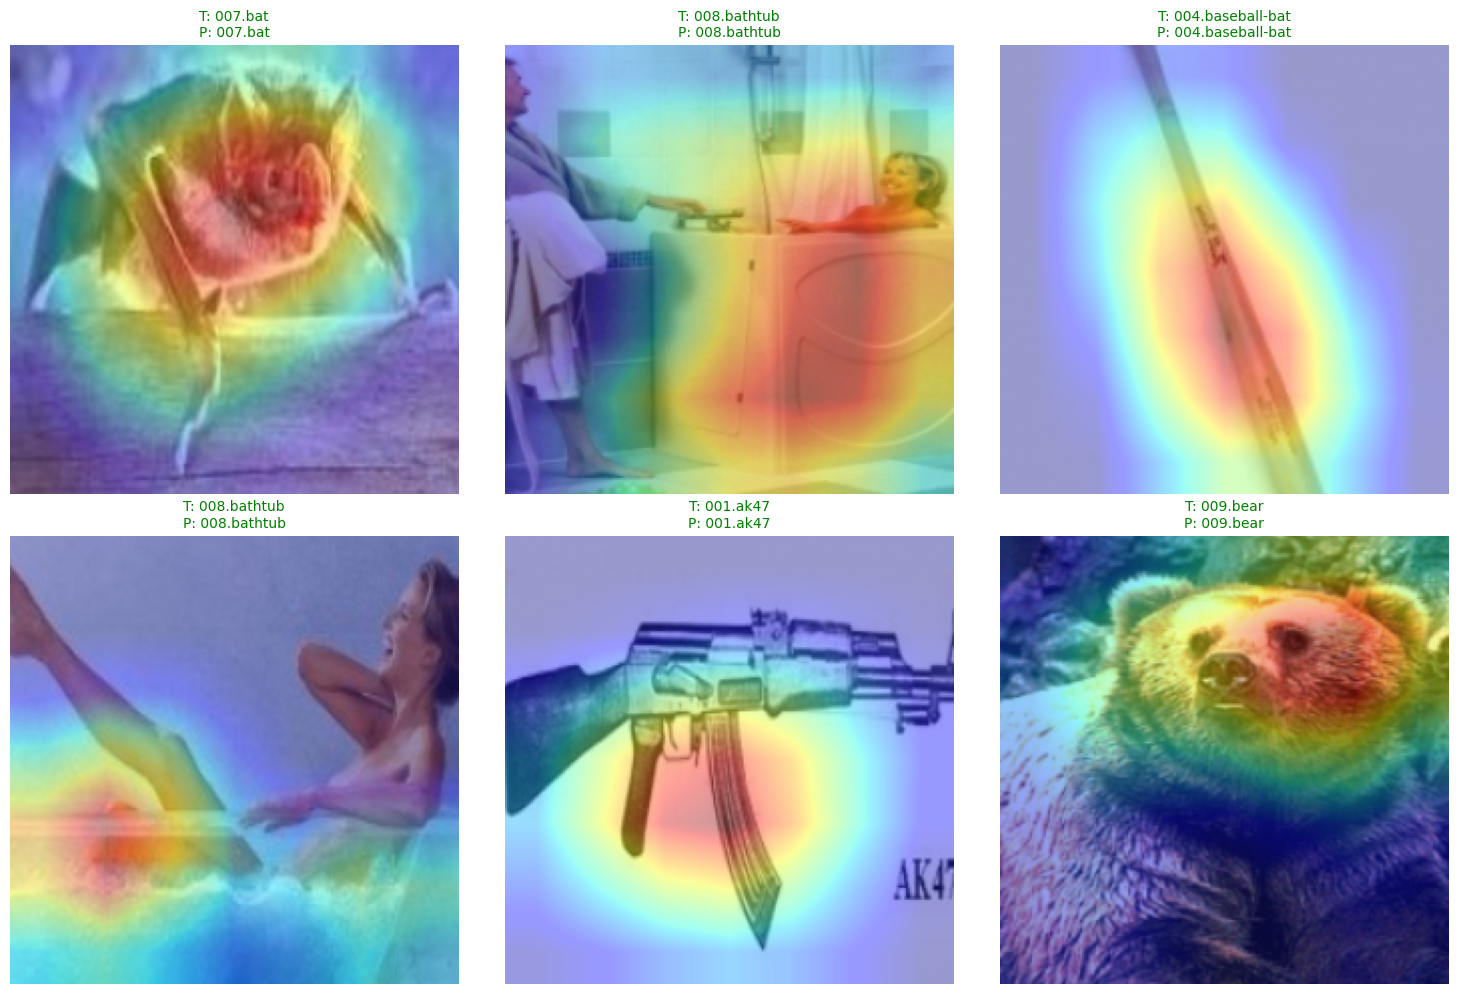

In [46]:
show_gradcam_gallery(
    model=model_ft,               # or model_final
    dataset=test_dataset,         # or val_dataset
    class_names=subset_class_names,      # your class names list
    num_images=6                  # number of images to show
)